In [36]:
import nibabel as nib
import matplotlib.pyplot as plt 
from matplotlib import patches
import numpy as np
import re
import os
import cv2
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import albumentations as augm
from albumentations.pytorch import ToTensorV2
import sklearn

In [37]:
def load_nifti_image(file_path):
    img = nib.load(file_path)
    img_data = img.get_fdata()
    return img_data

# Site 1

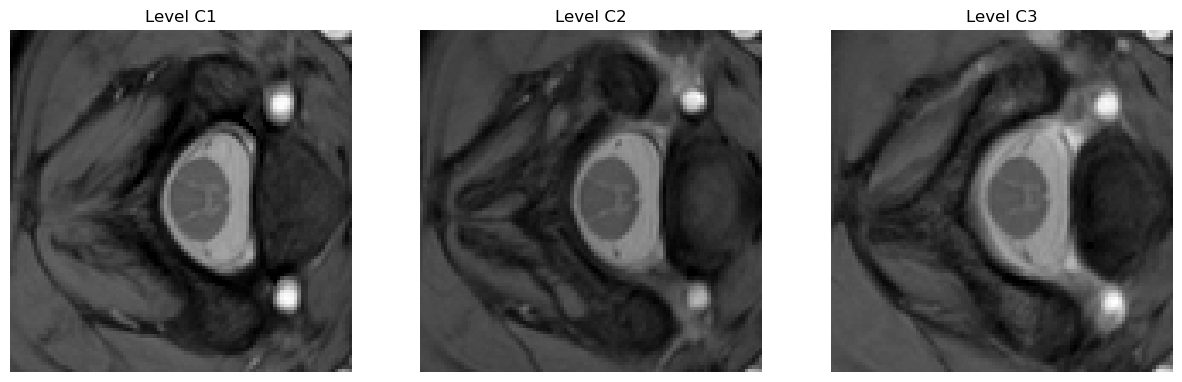

In [38]:
img_test = load_nifti_image('./train/site1-sc01-image.nii.gz')
plt.figure(figsize=(15,6))
for k in range(3):
    plt.subplot(1,3,k+1)
    plt.imshow(img_test[:,:,k], cmap='gray')
    plt.axis('off')
    plt.title(f'Level C{k+1}')

Site 2

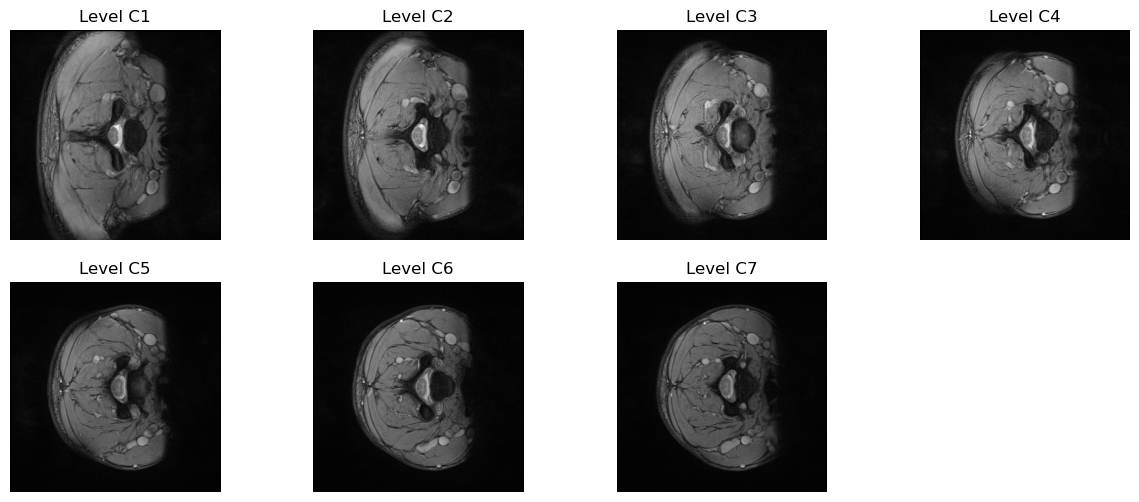

In [39]:
img_test = load_nifti_image('./train/site2-sc06-image.nii.gz')
plt.figure(figsize=(15,6))
for k in range(7):
    plt.subplot(2,4,k+1)
    plt.imshow(img_test[:,:,k], cmap='gray')
    plt.axis('off')
    plt.title(f'Level C{k+1}')

Site 3

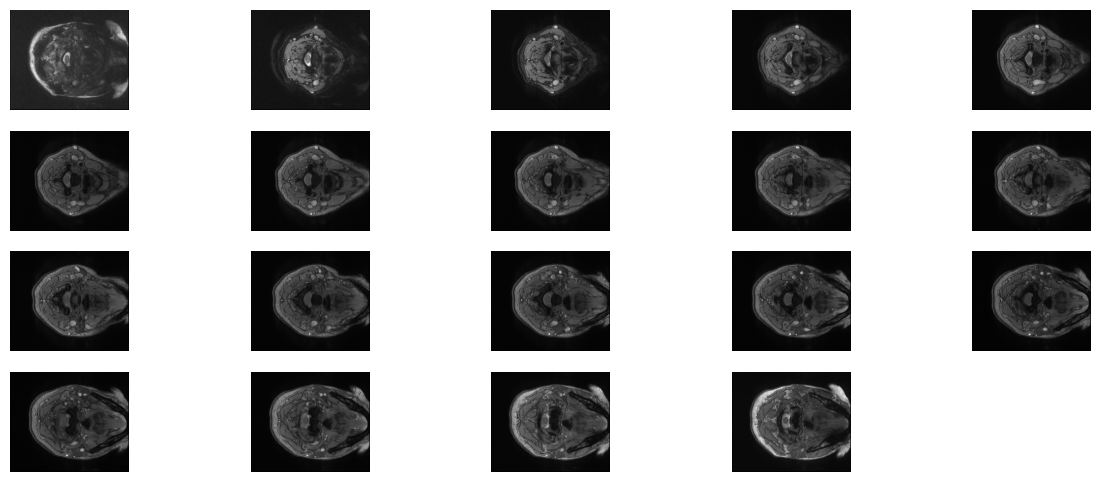

In [40]:
img_test = load_nifti_image('./train/site3-sc01-image.nii.gz')
img_test.shape
plt.figure(figsize=(15,6))
for k in range(4,23):
    plt.subplot(4,5,k-3)
    plt.imshow(img_test[:,:,k], cmap='gray')
    plt.axis('off')

Site 4

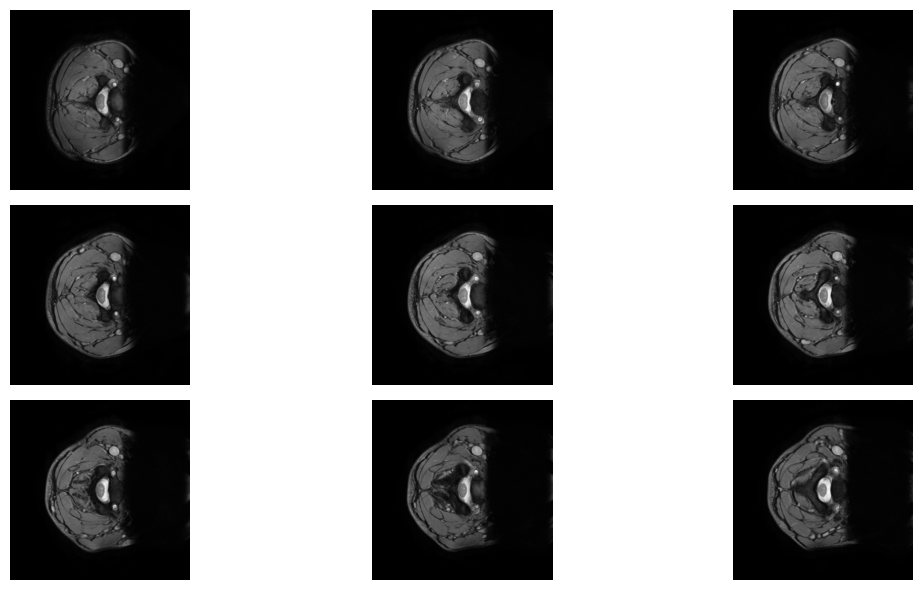

In [41]:
img_test = load_nifti_image('./train/site4-sc02-image.nii.gz')
img_test.shape
plt.figure(figsize=(15,6))
for k in range(3,12):
    plt.subplot(3,3,k-2)
    plt.imshow(img_test[:,:,k], cmap='gray')
    plt.axis('off')
    plt.tight_layout()

In [42]:
def binarize(mask):
    binarized_mask = np.zeros(mask.shape)
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            if mask[x,y] == 1:
                binarized_mask[x,y] = 1
            else:
                pass 
    return binarized_mask

def extract_mask_extrema(binary_mask):
    indices = np.argwhere(binary_mask == 1)
    xmin = np.min(indices[:,1])
    xmax = np.max(indices[:,1])
    ymin = np.max(indices[:,0])
    ymax = np.min(indices[:,0])
    return (xmin, xmax-xmin, ymax, ymin-ymax)

In [43]:
def crop_image_around_the_mask(img, binary_mask, SIZE_SQUARE=100, max_shift=30):
    (x, w, y, h) = extract_mask_extrema(binary_mask)
    width_to_add = round((SIZE_SQUARE - w) / 2)
    height_to_add = round((SIZE_SQUARE - h) / 2)
    
    shift_x = np.random.randint(-max_shift, max_shift)
    shift_y = np.random.randint(-max_shift, max_shift)

    y_min = max(0, y - height_to_add + shift_y)
    y_max = min(img.shape[0], y + height_to_add + h + shift_y)
    x_min = max(0, x - width_to_add + shift_x)
    x_max = min(img.shape[1], x + width_to_add + w + shift_x)
    if (y_max - y_min) != SIZE_SQUARE:
        if y_min == 0:
            y_max = SIZE_SQUARE
        else:
            y_min = y_max - SIZE_SQUARE
    if (x_max - x_min) != SIZE_SQUARE:
        if x_min == 0:
            x_max = SIZE_SQUARE
        else:
            x_min = x_max - SIZE_SQUARE
            
    cropped_img = img[y_min:y_max, x_min:x_max]
    cropped_mask = binary_mask[y_min:y_max, x_min:x_max]
    return cropped_img, cropped_mask


(-0.5, 99.5, 99.5, -0.5)

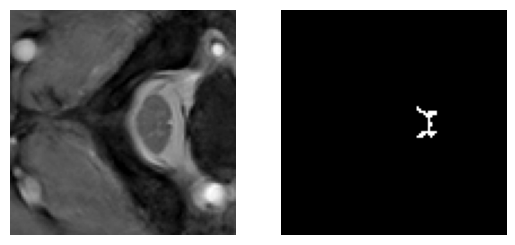

In [44]:
img_test_bis = load_nifti_image('./train/site1-sc02-image.nii.gz')[:,:,2]
mask_test_bis = load_nifti_image('./train/site1-sc02-mask-r1.nii.gz')[:,:,2]
cropped_img, cropped_mask = crop_image_around_the_mask(img_test_bis, binarize(mask_test_bis), SIZE_SQUARE=500, max_shift=1)
plt.subplot(1,2,1)
plt.imshow(cropped_img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cropped_mask, cmap='gray')
plt.axis('off')

In [45]:
def get_levels(filename):
    list_levels = []
    with open(filename, 'r') as file:
        lines = file.readlines()
    for line in lines[1:]:
        try:
            levels_in_file = re.findall('(,)(.*)', line)[0][1]
            list_levels.append(int(levels_in_file.strip()[0]))
        except:
            list_levels.append(None)
    return list_levels

In [46]:
dict_filepaths={}
filename_img = []
filename_levels = []
filename_masks = []
for site_index in range(1,5):
    for irm_index in range(1,11):
        if irm_index < 10:
            name_index = '0' + str(irm_index)
        else:
            name_index = '10'
        filename_img.append('./train/site'+str(site_index)+'-sc'+name_index+'-image.nii.gz')
        filename_levels.append('./train/site'+str(site_index)+'-sc'+name_index+'-levels.txt')
        filename_masks.append(['./train/site'+str(site_index)+'-sc'+name_index+'-mask-r'+str(i)+'.nii.gz' for i in range(1,5)])

In [47]:
for k in range(len(filename_img)):
    dict_filepaths['MRI'+str(k)]={
            'site' : int(filename_img[k][12:13]),
            'filename_img' : filename_img[k],
            'filename_levels' : filename_levels[k],
            'filename_masks' : filename_masks[k]
    }

In [48]:
dict_filepaths['MRI0']

{'site': 1,
 'filename_img': './train/site1-sc01-image.nii.gz',
 'filename_levels': './train/site1-sc01-levels.txt',
 'filename_masks': ['./train/site1-sc01-mask-r1.nii.gz',
  './train/site1-sc01-mask-r2.nii.gz',
  './train/site1-sc01-mask-r3.nii.gz',
  './train/site1-sc01-mask-r4.nii.gz']}

In [49]:
def majoritary_mask(masks_paths):
    mask1 = load_nifti_image(masks_paths[0])
    mask2 = load_nifti_image(masks_paths[1])
    mask3 = load_nifti_image(masks_paths[2])
    mask4 = load_nifti_image(masks_paths[3])
    mask_majoritary_vote = []
    for slice in range(mask1.shape[2]):
        binary_slice_mask1 = binarize(mask1[:,:,slice])
        binary_slice_mask2 = binarize(mask2[:,:,slice])
        binary_slice_mask3 = binarize(mask3[:,:,slice])
        binary_slice_mask4 = binarize(mask4[:,:,slice])
        sum_binary_slice = binary_slice_mask1 + binary_slice_mask2 + binary_slice_mask3 + binary_slice_mask4
        binary_slice = (sum_binary_slice>2).astype('uint8')
        mask_majoritary_vote.append(binary_slice)
    return np.moveaxis(np.array(mask_majoritary_vote), 0, -1)

In [50]:
def display_image_and_its_mask(img, mask):
    img_normalized = np.copy(img) / np.max(img)
    img_with_mask = np.copy(img_normalized)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if mask[x,y]==1:
                img_with_mask[x,y]=1
            else:
                pass
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.imshow(img_normalized, cmap='gray')
    plt.axis('off')
    plt.title('Base image')

    plt.subplot(1,2,2)
    plt.imshow(img_with_mask, cmap='gray')
    plt.axis('off')
    plt.title('Image with mask')

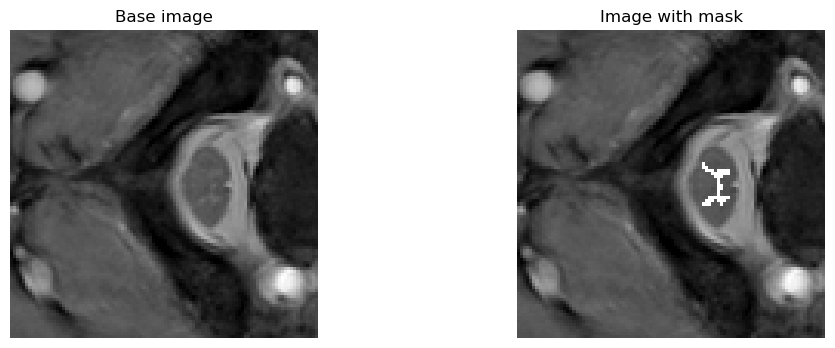

In [51]:
display_image_and_its_mask(cropped_img, cropped_mask)

In [53]:
def remove_null_image(mri, mask, levels):
    (x,y,_) = mri.shape
    levels_without_none = []
    mri_without_null = []
    mask_without_null = []
    for i in range(len(levels)):
        if levels[i] is None or np.array_equal(mask[:,:,i], np.zeros((x,y))):
            pass
        else:
            levels_without_none.append(levels[i])
            mri_without_null.append(mri[:,:,i])
            mask_without_null.append(mask[:,:,i])
    return np.moveaxis(np.array(mri_without_null), 0, -1), np.moveaxis(np.array(mask_without_null), 0, -1), levels_without_none

In [54]:
def load_mri_slices(dict_filepaths, MRI_index):
    name_mri = 'MRI'+str(MRI_index)
    mri = load_nifti_image(dict_filepaths[name_mri]['filename_img'])
    levels = get_levels(dict_filepaths[name_mri]['filename_levels'])
    mask = majoritary_mask(dict_filepaths[name_mri]['filename_masks'])
    mri_formated, mask_formated, levels_formated = remove_null_image(mri, mask, levels)
    return mri_formated, mask_formated, levels_formated

In [55]:
MRI_SLICES_PATH = './data_formated/MRI_slices/'
MASK_SLICES_PATH = './data_formated/masks_slices/'
def save_slice_as_single_file(dict_filepaths, index, filepath_slices_mri = MRI_SLICES_PATH, filepath_slices_masks = MASK_SLICES_PATH):
    cropping_factors = [[500,1],[100,30],[200,60],[150,55]]
    cropping_index = index//10
    mri, mask, levels = load_mri_slices(dict_filepaths, index)
    os.makedirs(filepath_slices_mri, exist_ok=True)
    os.makedirs(filepath_slices_masks, exist_ok=True)
    (_,_,nb_slices) = mri.shape
    for slice_index in range(nb_slices):
        mask_slice = mask[:,:,slice_index]
        binary_mask_slice = binarize(mask_slice)
        mri_slice = mri[:,:,slice_index]
        
        mri_slice_formated, mask_slice_formated = crop_image_around_the_mask(mri_slice, binary_mask_slice, SIZE_SQUARE=cropping_factors[cropping_index][0], max_shift=cropping_factors[cropping_index][1])
        
        mri_slice_formated = cv2.resize(mri_slice_formated, (256,256), interpolation=cv2.INTER_LINEAR)
        mask_slice_formated = cv2.resize(mask_slice_formated, (256,256), interpolation=cv2.INTER_LINEAR)
        
        np.save(os.path.join(filepath_slices_mri, f'IRM{index}_slice_{slice_index}.npy'), mri_slice_formated)
        np.save(os.path.join(filepath_slices_masks, f'Mask{index}_slice_{slice_index}.npy'), mask_slice_formated)

In [56]:
for mri_index_in_dict in range(len(dict_filepaths)):
    save_slice_as_single_file(dict_filepaths, mri_index_in_dict)

In [57]:
# # Corrections manuelles erreur d'annotations
# for k in range(0,40):
#     name_mri = 'MRI'+str(k)
#     mri = load_nifti_image(dict_filepaths[name_mri]['filename_img'])
#     levels = get_levels(dict_filepaths[name_mri]['filename_levels'])
#     for ind in range(4):
#         if len(levels)!=load_nifti_image(dict_filepaths[name_mri]['filename_masks'][0]).shape[2]:
#             print (f'{k} : {dict_filepaths[name_mri]['filename_levels']} : Levels len = {len(levels)}, Mask shape = {load_nifti_image(dict_filepaths[name_mri]['filename_masks'][0]).shape}')

In [58]:
def plot_sample(index):
    mri_array = np.load('./data_formated/MRI_slices/IRM'+str(index)+'_slice_0.npy')
    mask_array = np.load('./data_formated/masks_slices/Mask'+str(index)+'_slice_0.npy')
    print(mri_array.shape)
    plt.subplot(1,2,1)
    plt.imshow(mri_array, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(mask_array, cmap='gray')
    plt.axis('off')

(256, 256)
(256, 256)
(256, 256)
(256, 256)


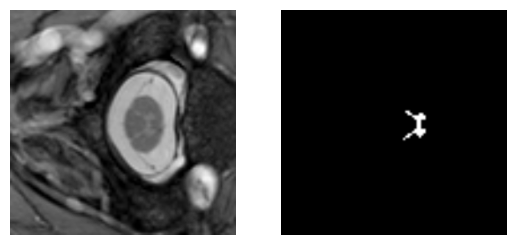

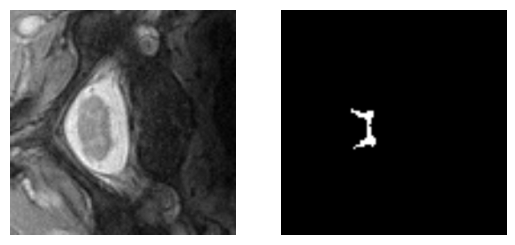

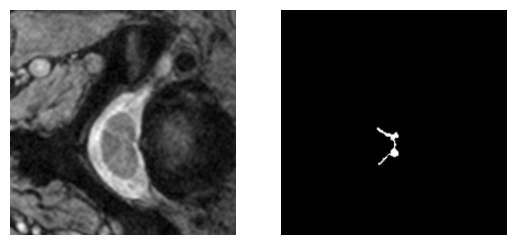

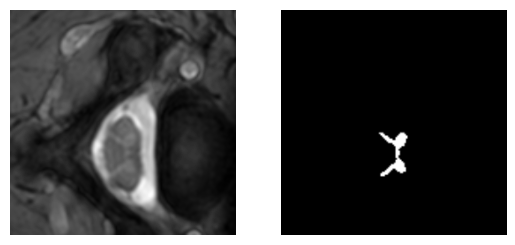

In [59]:
index1=np.random.randint(0,10)
index2=np.random.randint(10,20)
index3=np.random.randint(20,30)
index4=np.random.randint(30,40)
plt.figure()
plot_sample(index1)
plt.figure()
plot_sample(index2)
plt.figure()
plot_sample(index3)
plt.figure()
plot_sample(index4)

In [60]:
for file in os.scandir('./data_formated/masks_slices/'):
    img = np.load(file.path)
    if np.array_equal(img, np.zeros((100,100))):
        print(f'Bad mask, file {file.path}') 

In [61]:
class SpinalCordDataset(Dataset):
    def __init__(self, irm_slices_path, mask_slices_path, transform = None):
        self.irm_slices_path = irm_slices_path
        self.mask_slices_path = mask_slices_path
        self.transform = transform
        
        self.irm_files = [f for f in os.listdir(irm_slices_path) if f.startswith("IRM") and f.endswith(".npy")]
        self.data_pairs = []
        for irm_file in self.irm_files:
            mask_file = 'Mask' + irm_file[3:]
            self.data_pairs.append((irm_file, mask_file))

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        irm_file, mask_file = self.data_pairs[idx]
        irm_path = os.path.join(self.irm_slices_path, irm_file)
        mask_path = os.path.join(self.mask_slices_path, mask_file)

        irm = np.load(irm_path)
        mask = np.load(mask_path) 

        irm = (irm - irm.min()) / (irm.max() - irm.min())
        irm_uint8 = (irm * 255).astype(np.uint8)
        
        if self.transform:
            augmented = self.transform(image=irm_uint8, mask=mask)
            irm_tensor = augmented['image']  
            mask_tensor = augmented['mask']
        else:
            irm_tensor = torch.from_numpy(irm).float().unsqueeze(0)
            mask_tensor = torch.from_numpy(mask).long()

        return irm_tensor, mask_tensor

In [62]:
irm_slices_path = './data_formated/MRI_slices'
mask_slices_path =  './data_formated/masks_slices'

transform = augm.Compose([
    augm.CLAHE(clip_limit=4.0, tile_grid_size=(8,8), p=0.3),
    augm.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    augm.RandomRotate90(p=0.25),
    augm.Normalize(mean=[0.5], std=[0.5]),
    ToTensorV2()  
])

dataset = SpinalCordDataset(irm_slices_path, mask_slices_path, transform)

torch.Size([1, 256, 256]) torch.Size([256, 256])


(-0.5, 255.5, 255.5, -0.5)

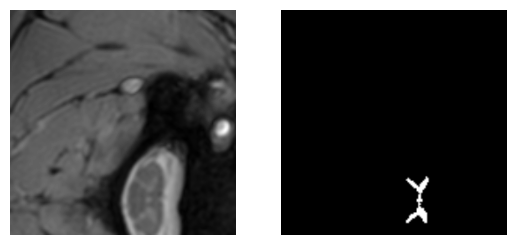

In [63]:
irm_tensor, mask_tensor = dataset[125]
print(irm_tensor.shape, mask_tensor.shape)

plt.subplot(1,2,1)
plt.imshow(irm_tensor[0,:,:], cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask_tensor, cmap='gray')
plt.axis('off')

In [64]:
from sklearn.model_selection import train_test_split

dataset_train, dataset_test_tmp = train_test_split(dataset, test_size=0.15, random_state=11)
dataset_test, dataset_val = train_test_split(dataset_test_tmp, test_size=0.5, random_state=11)

In [65]:
dataloader_train = DataLoader(dataset_train, batch_size=4, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=2, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=2, shuffle=True)

In [66]:
class U_net_model(nn.Module):
    def __init__(self):
        super().__init__()
        pass

In [67]:
class bloc_convo1(nn.Module):
    def __init__(self, input_size, hidden_size = 64, output_size = 64):
        super().__init__(),
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.activation = nn.ReLU()

        self.CNN1 = nn.Conv2d(
            in_channels = self.input_size,
            out_channels = self.hidden_size,
            kernel_size = (3,3),
            padding=(1,1))
        
        self.CNN2 = nn.Conv2d(
            in_channels = self.hidden_size,
            out_channels = self.output_size,
            kernel_size = (3,3),
            padding=(1,1))

    def forward(self, x):
        x = self.CNN1(x)
        x = self.activation(x)
        x = self.CNN2(x)
        x = self.activation(x)
        return x

In [68]:
class bloc_convo2(nn.Module):
    def __init__(self, input_size = 64, hidden_size = 128, output_size = 128):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.activation = nn.ReLU()
        
        self.MaxPool2D = nn.MaxPool2d(
            kernel_size=(2,2))
        
        self.CNN1 = nn.Conv2d(
            in_channels = self.input_size,
            out_channels = self.hidden_size,
            kernel_size = (3,3),
            padding=(1,1))
        
        self.CNN2 = nn.Conv2d(
            in_channels = self.hidden_size,
            out_channels = self.output_size,
            kernel_size = (3,3),
            padding=(1,1))

    def forward(self, x):
        x = self.MaxPool2D(x)
        x = self.CNN1(x)
        x = self.activation(x)
        x = self.CNN2(x)
        x = self.activation(x)
        return x

In [69]:
class bloc_convo3(nn.Module):
    def __init__(self, input_size = 128, hidden_size = 256, output_size = 256):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.activation = nn.ReLU()
        
        self.MaxPool2D = nn.MaxPool2d(
            kernel_size=(2,2))
        
        self.CNN1 = nn.Conv2d(
            in_channels = self.input_size,
            out_channels = self.hidden_size,
            kernel_size = (3,3),
            padding=(1,1))
        
        self.CNN2 = nn.Conv2d(
            in_channels = self.hidden_size,
            out_channels = self.output_size,
            kernel_size = (3,3),
            padding=(1,1))

    def forward(self, x):
        x = self.MaxPool2D(x)
        x = self.CNN1(x)
        x = self.activation(x)
        x = self.CNN2(x)
        x = self.activation(x)
        return x

In [70]:
class bloc_convo4(nn.Module):
    def __init__(self, input_size = 256, hidden_size = 512, output_size = 512):
        super().__init__(),
        self.input_size = input_size,
        self.hidden_size = hidden_size,
        self.output_size = output_size,

        self.activation = nn.ReLU()
        
        self.MaxPool2D = nn.MaxPool2d(
            kernel_size=(2,2)),
        
        self.CNN1 = nn.Conv2d(
            in_channels = self.input_size,
            out_channels = self.hidden_size,
            kernel_size = (3,3),
            padding=(1,1)),
        
        self.CNN2 = nn.Conv2d(
            in_channels = self.hidden_size,
            out_channels = self.output_size,
            kernel_size = (3,3),
            padding=(1,1))

    def forward(self, x):
        x = self.MaxPool2D(x)
        x = self.CNN1(x)
        x = self.activation(x)
        x = self.CNN2(x)
        x = self.activation(x)
        return x